<a href="https://colab.research.google.com/github/kairamilanifitria/NLP-A/blob/main/Project%201%20Sentiment%20Analysis/Project1_Best_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import AdamW
from transformers import Trainer, TrainingArguments

from sklearn.ensemble import RandomForestClassifier

In [4]:
data = pd.read_csv('/content/best_dataset.csv')
data

,sentimen,tweet_clean
0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,netral,batuan langka tasbih jokowi hadiah dari habib ...
2,netral,di era jokowi ekonomi indonesia semakin baik 0...
3,positif,bagi sumatera selatan asian games berdampak pa...
4,negatif,negara kita ngutang buat bangun infrastruktur ...
...,...,...
1810,netral,negarawan sejati selalu bangga dan mengedepank...
1811,netral,1 harus ceramah di damai indonesiaku 2 perekon...
1812,netral,mari bangun bangsa dengan mendukung perekonomi...
1813,netral,bantu majukan perekonomian bangsa bersama pak ...


# TEMPLATE

In [5]:
# Label Encoder
label_encoder = LabelEncoder()
data['encoded_labels'] = label_encoder.fit_transform(data['sentimen'])

# Split
X = data['tweet_clean']
y = data['encoded_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (1452,)
Testing Data :  (363,)


In [6]:
# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load IndoBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis')
bert_model = BertModel.from_pretrained('Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis').to(device)

# Step 1: Preprocess text using IndoBERT Tokenizer
def preprocess(texts):
    # Tokenize the text using IndoBERT tokenizer
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)

# Step 2: Create BERT embeddings
def get_bert_embeddings(texts):
    tokens = preprocess(texts)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embeddings

# Get embeddings for train and test data
X_train_embeddings = get_bert_embeddings(X_train.tolist())
X_test_embeddings = get_bert_embeddings(X_test.tolist())

Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.77      0.68       115
           1       0.70      0.58      0.64       118
           2       0.67      0.63      0.65       130

    accuracy                           0.66       363
   macro avg       0.66      0.66      0.66       363
weighted avg       0.66      0.66      0.66       363



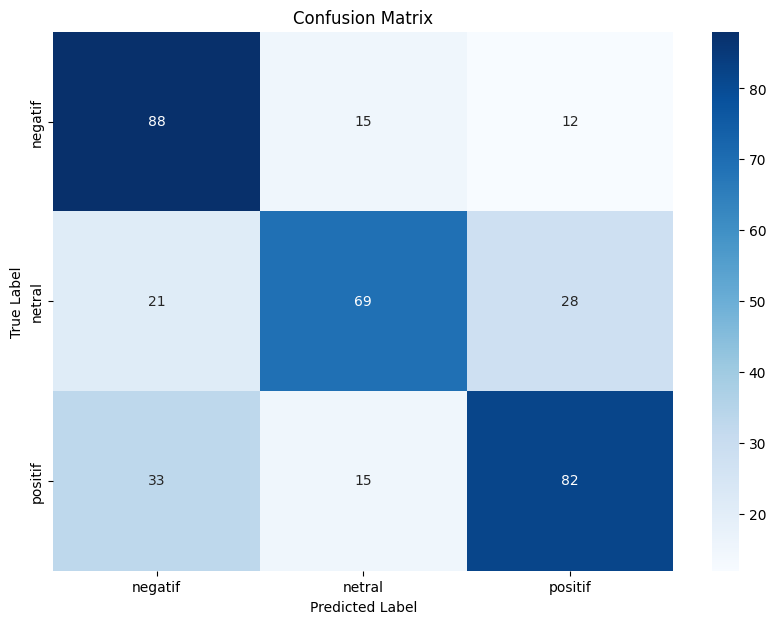

In [7]:
# Step 3: Model Training and Evaluation (Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_embeddings, y_train)

y_pred_rf = rf_model.predict(X_test_embeddings)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

classes = label_encoder.classes_

# Plot the confusion matrix with class names
plot_confusion_matrix(cm, classes)

In [8]:
# prompt: make a code to show the parameter model of random forest summary

# Print the parameters of the Random Forest model
print("Random Forest Model Parameters:")
for param_name, param_value in rf_model.get_params().items():
    print(f"{param_name}: {param_value}")


Random Forest Model Parameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


Epoch [1/100], Loss: 1.0842, Accuracy: 0.4421, F1 Score: 0.3545
Epoch [2/100], Loss: 1.0224, Accuracy: 0.5034, F1 Score: 0.4066
Epoch [3/100], Loss: 0.9953, Accuracy: 0.5069, F1 Score: 0.4134
Epoch [4/100], Loss: 0.9973, Accuracy: 0.5172, F1 Score: 0.4321
Epoch [5/100], Loss: 0.9857, Accuracy: 0.5289, F1 Score: 0.4669
Epoch [6/100], Loss: 0.9789, Accuracy: 0.5475, F1 Score: 0.5252
Epoch [7/100], Loss: 0.9641, Accuracy: 0.5702, F1 Score: 0.5559
Epoch [8/100], Loss: 0.9452, Accuracy: 0.5971, F1 Score: 0.5955
Epoch [9/100], Loss: 0.9479, Accuracy: 0.5978, F1 Score: 0.5963
Epoch [10/100], Loss: 0.9347, Accuracy: 0.6054, F1 Score: 0.6050
Epoch [11/100], Loss: 0.9226, Accuracy: 0.6185, F1 Score: 0.6194
Epoch [12/100], Loss: 0.9048, Accuracy: 0.6384, F1 Score: 0.6378
Epoch [13/100], Loss: 0.9118, Accuracy: 0.6391, F1 Score: 0.6380
Epoch [14/100], Loss: 0.8979, Accuracy: 0.6453, F1 Score: 0.6455
Epoch [15/100], Loss: 0.9010, Accuracy: 0.6446, F1 Score: 0.6446
Epoch [16/100], Loss: 0.8966, Accu

<ipython-input-6-023dca1bfa13>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


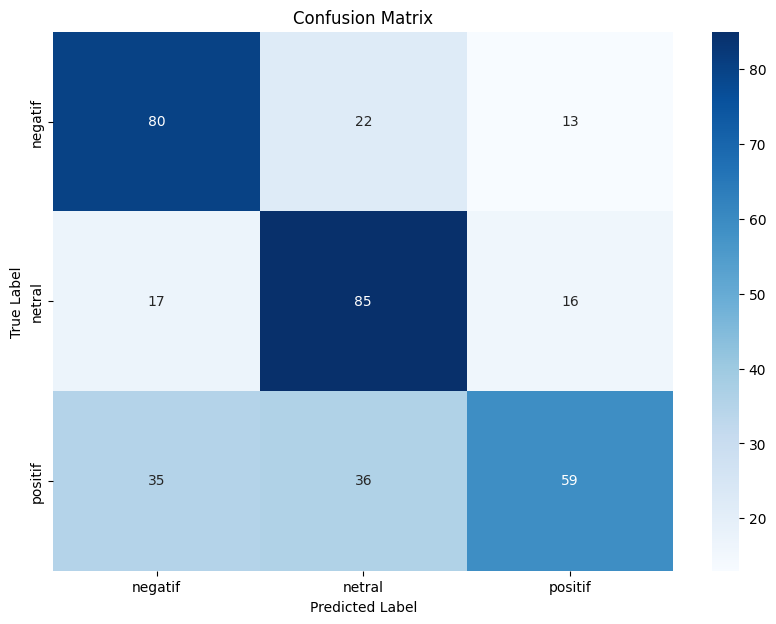

0.6170798898071626 0.6107965210756556


In [6]:

# Custom Dataset class for LSTM
class LSTMDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Create datasets
train_dataset = LSTMDataset(X_train_embeddings, y_train.tolist())
test_dataset = LSTMDataset(X_test_embeddings, y_test.tolist())

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# LSTM Model Definition with enhancements
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for multi-class classification

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Get the last time step's output with dropout
        return self.softmax(self.fc(out))  # Apply softmax activation

# Hyperparameters
input_size = X_train_embeddings.shape[1]
hidden_size = 32  # Adjust based on your needs
num_layers = 3     # Adjust based on your needs
output_size = len(label_encoder.classes_)
num_epochs = 100
patience = 10  # Early stopping patience

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop with Early Stopping
best_loss = np.inf
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    y_true = []
    y_pred = []

    for batch_embeddings, batch_labels in train_loader:
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate metrics
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = accuracy_score(y_true, y_pred)
    avg_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, F1 Score: {avg_f1:.4f}")

    # Early Stopping Check
    if avg_loss < best_loss:
        best_loss = avg_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation Loop
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_embeddings, batch_labels in test_loader:
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        outputs = model(batch_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

cm = confusion_matrix(y_true, y_pred)
# Classification Report
print(classification_report(y_true, y_pred))
plot_confusion_matrix(cm, classes)
print(accuracy, f1)

# FIX TEST

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/best_dataset.csv')
df

,sentimen,tweet_clean
0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,netral,batuan langka tasbih jokowi hadiah dari habib ...
2,netral,di era jokowi ekonomi indonesia semakin baik 0...
3,positif,bagi sumatera selatan asian games berdampak pa...
4,negatif,negara kita ngutang buat bangun infrastruktur ...
...,...,...
1810,netral,negarawan sejati selalu bangga dan mengedepank...
1811,netral,1 harus ceramah di damai indonesiaku 2 perekon...
1812,netral,mari bangun bangsa dengan mendukung perekonomi...
1813,netral,bantu majukan perekonomian bangsa bersama pak ...


In [ ]:

# Assuming you have already lemmatized your text
lemmatized_texts = df['tweet_clean']
sentiment_labels = df['sentimen']

# Convert sentiment labels to numeric format
label_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
numeric_labels = [label_mapping[label] for label in sentiment_labels]

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')
model = BertModel.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

def vectorize_text_bert(text, tokenizer, model):
    # Tokenize and convert text to BERT input format
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the mean of the last hidden state as the text representation
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Vectorize all lemmatized texts
vectorized_texts_bert = np.array([vectorize_text_bert(text, tokenizer, model) for text in df['tweet_clean']])

print("BERT Vectorized Texts Shape:", vectorized_texts_bert.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

BERT Vectorized Texts Shape: (1815, 768)


In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.models import Sequential # Import Sequential from tensorflow.keras.models
from tensorflow.keras.layers import LSTM, Dropout, Dense # Import LSTM, Dropout, and Dense
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping


In [ ]:

# ---------------------------- LSTM ----------------------------
# Use the same BERT vectorized embeddings as in Random Forest
X = vectorized_texts_bert
y = numeric_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM, but note that since BERT embeddings are static (not sequential),
# you don't need to add an extra dimension like with Word2Vec.
X_train = np.expand_dims(X_train, axis=1)  # Add a dummy "time step" axis
X_test = np.expand_dims(X_test, axis=1)

# Convert y_train to a NumPy array
y_train = np.array(y_train)

# Define the LSTM model using Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Continue with Keras Tuner for hyperparameter tuning (same as before)
tuner = kt.BayesianOptimization(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=20,
    directory='my_tuning',
    project_name='bert_lstm'
)

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hps.values}")

Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.7216494679450989

Best val_accuracy So Far: 0.7422680258750916
Total elapsed time: 00h 01m 53s
Best Hyperparameters: {'units': 64, 'dropout': 0.2, 'dense_units': 128, 'optimizer': 'adam'}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │         213,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,955 (867.01 KB)

 Trainable params: 221,955 (867.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5898 - loss: 0.9306 - val_accuracy: 0.6942 - val_loss: 0.7122
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6740 - loss: 0.7636 - val_accuracy: 0.6942 - val_loss: 0.7192
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7214 - loss: 0.6742 - val_accuracy: 0.7216 - val_loss: 0.6560
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7013 - loss: 0.6606 - val_accuracy: 0.7113 - val_loss: 0.6744
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7417 - loss: 0.6175 - val_accuracy: 0.7216 - val_loss: 0.6712
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7609 - loss: 0.5792 - val_accuracy: 0.7079 - val_loss: 0.6973
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test Accuracy: 0.696969696969697
Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.84      0.74       115
     neutral       0.80      0.62 

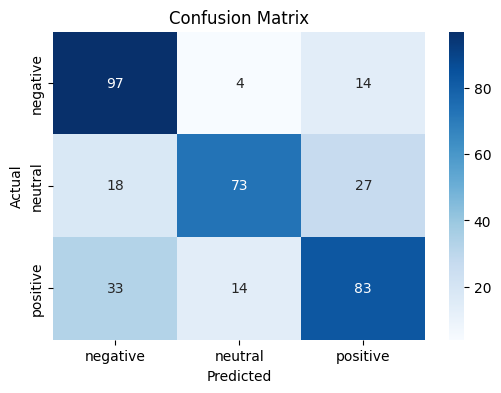

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Best Hyperparameters: {'units': 64, 'dropout': 0.2, 'dense_units': 128, 'optimizer': 'adam'}
# Function to build LSTM model with best hyperparameters
def build_best_lstm_model():
    model = Sequential()

    # LSTM layer
    model.add(LSTM(
        units=64,                      # Best 'units' value
        input_shape=(X_train.shape[1], X_train.shape[2]),  # Input shape
        return_sequences=False
    ))

    # Dropout layer to prevent overfitting
    model.add(Dropout(rate=0.2))         # Best 'dropout' value

    # Dense layer
    model.add(Dense(
        units=128,                        # Best 'dense_units' value
        activation='relu'
    ))

    # Output layer (3 classes: negative, neutral, positive)
    model.add(Dense(3, activation='softmax'))

    # Compile the model using the best optimizer
    model.compile(
        optimizer='adam',                # Best 'optimizer' value
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the LSTM model using the best hyperparameters
best_lstm_model = build_best_lstm_model()

# Display the model architecture
best_lstm_model.summary()

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

best_lstm_model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
y_pred_probs = best_lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
